In [1]:
import math, torch, umap, hdbscan

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import altair as alt

from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.feature_extraction.text import CountVectorizer

/Users/faustogerman/miniforge3/envs/applied-ml-project/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ViTopic – Topic Modeling on Images by Clustering of Vision Transformer Embeddings
Image data plays a critical role in many fields such as social media analysis, medical imaging, and marketing. However, collecting, sorting, clustering, and labeling large amounts of image data can be a challenging and time-consuming task that often requires significant human resources. The proposed work aims to develop an automated system that can cluster and describe large datasets of unlabeled images, allowing analysts to quickly and accurately process vast amounts of visual data. This project's primary objective is to create a tool that can help people automatically cluster images into groups and generate text-based topics for each cluster, which will help them extract meaningful insights from the data. By automating this process, the system will significantly improve image data processing efficiency, reduce labor costs, and facilitate the analysis of visual data.

In general, this technique demonstrated in this notebook is as follows:
```
                            ---> SIMILARITY MATRIX -> Context-Based Image Search
IMAGES -> EMBEDDINGS -> ---|
                            ---> UMAP -> HDBSCAN -> TF_IDF MATRIX -> Text-Based DESCRIPTORS (top words)
```

The end result is a system that can take a set of unlabeled images and cluster them by their similarities while also generating text-based descriptors of the clusters.

## Load the Data
NOTE: This data was processed using Google Colab. Visit the `./data-processing.colab.ipynb` for more info.

In [2]:
DATA = pd.read_pickle("./processed_images.pkl").reset_index(drop=True)

DATA.head(10)

image  category   
0  [[[43, 39, 62], [41, 36, 60], [40, 36, 59], [4...         0  \
1  [[[255, 255, 251], [255, 255, 251], [255, 255,...         0   
2  [[[181, 170, 152], [193, 182, 164], [192, 181,...         0   
3  [[[110, 135, 108], [110, 136, 111], [126, 151,...         0   
4  [[[60, 60, 54], [71, 72, 66], [87, 88, 82], [6...         0   
5  [[[62, 78, 93], [78, 93, 100], [46, 59, 55], [...         0   
6  [[[89, 100, 62], [88, 99, 63], [86, 99, 62], [...         0   
7  [[[28, 39, 42], [41, 50, 51], [26, 27, 26], [1...         0   
8  [[[14, 14, 16], [17, 17, 14], [19, 21, 13], [1...         0   
9  [[[241, 234, 242], [240, 233, 241], [240, 233,...         0   

                                   attention_weights   
0  [0.05418964475393295, 0.02181175723671913, 0.7...  \
1  [0.05811980739235878, 0.010085792280733585, 0....   
2  [0.04152180999517441, 0.26502525806427, 0.7568...   
3  [0.06863167136907578, 0.020426800474524498, 0....   
4  [0.07256149500608444, 0.014937695115804672, 0....   
5  [0.05764802172780037, 0.014075380750000477, 0....   
6  [0.0662599727511406, 0.34434983134269714, 0.72...   
7  [0.061309389770030975, 0.003364884527400136, 0...   
8  [0.051969386637210846, 0.029189063236117363, 0...   
9  [0.0736641213297844, 0.04883800819516182, 0.01...   

                                           embedding   
0  [0.3958092927932739, -0.41102686524391174, 0.0...  \
1  [0.04505084827542305, 0.4904085695743561, 0.07...   
2  [0.5317907929420471, -0.8023494482040405, 0.09...   
3  [0.30099257826805115, -0.8238896131515503, 0.0...   
4  [0.30781498551368713, -0.7023441791534424, 0.0...   
5  [0.7111724019050598, -0.5589199066162109, 0.08...   
6  [0.04077564552426338, -1.018877625465393, 0.03...   
7  [0.8744530081748962, -1.0580391883850098, 0.06...   
8  [0.3439618647098541, -0.43565893173217773, 0.0...   
9  [0.007255557458847761, -0.6717242002487183, 0....   

                                            captions  
0  there is a man kneeling down holding a fish in...  
1  arafed fish caught on a fishing trip in the co...  
2  arafed man holding a fish on a beach near a bo...  
3  arafed fish caught in the river by a man in a ...  
4    a man kneeling down holding a fish in his hands  
5         arafed man holding a fish in a wooded area  
6  boy holding a fish in his hands while sitting ...  
7      araffe fish in a net with a yellow fish on it  
8           araffe fish caught in the woods by a man  
9  arafed boy holding a fish in a field with a fi...

## Display Sample Images

<Figure size 640x480 with 0 Axes>

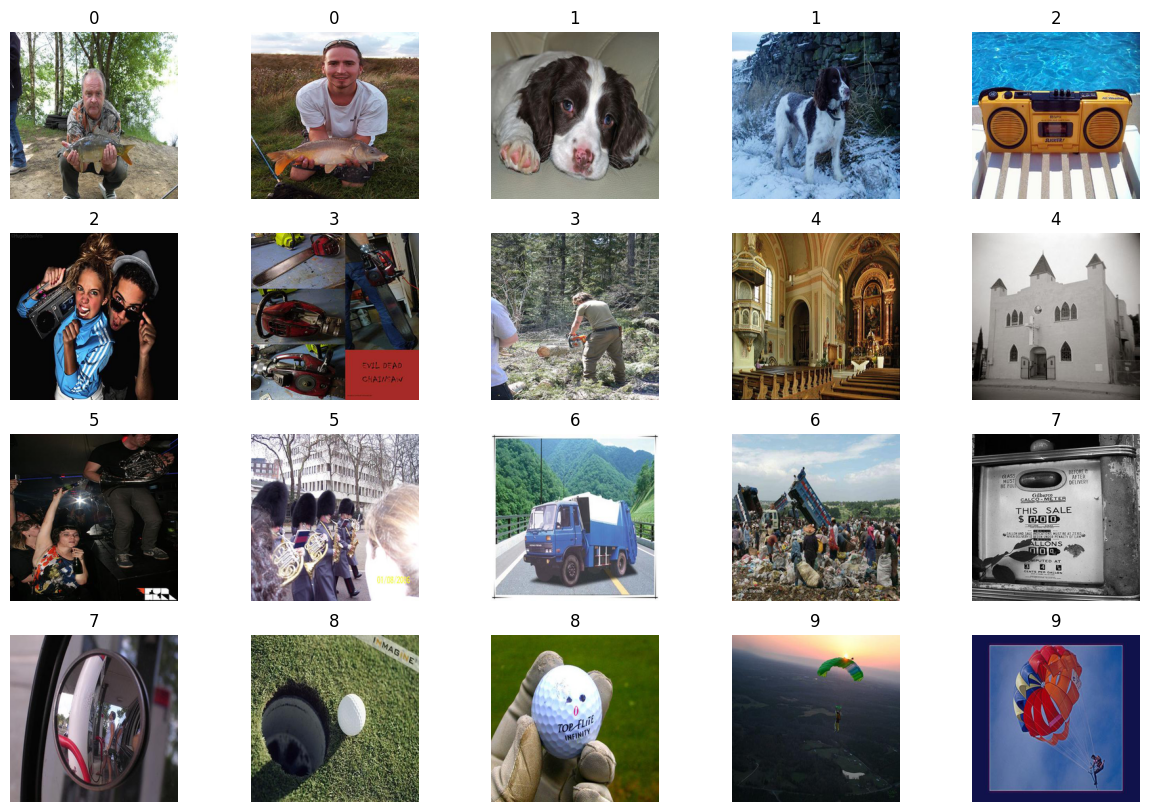

In [3]:
to_print = DATA.groupby('category', as_index=False).head(2).sort_values("category")

plt.clf()
_, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,10))

for idx in range(len(to_print)):
    sub_ax = ax[int(np.floor(idx / 5))][idx % 5]
    sub_ax.axis('off')

    if idx < len(to_print):
        row = to_print.iloc[idx]
        sub_ax.imshow(row["image"])
        sub_ax.set_title(row["category"])

plt.show()

## Display Output Attentions & Embedding Similarity

In [4]:
def plot_embed_comparison(data, idx1, idx2, sim_threshold):
    im1_data = data.iloc[idx1]
    im2_data = data.iloc[idx2]

    embed_size = len(im1_data["embedding"])
    atten_size = len(im1_data["attention_weights"])

    _, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,12))
    
    # Turn off all axes
    ax[0, 0].axis("off")
    ax[0, 1].axis("off")
    ax[0, 2].axis("off")
    ax[1, 0].axis("off")
    ax[1, 1].axis("off")
    ax[1, 2].axis("off")
    ax[2, 0].axis("off")
    ax[2, 1].axis("off")
    ax[2, 2].axis("off")

    # Display the images
    ax[0, 0].set_title(f"Image #{idx1}")
    ax[0, 0].imshow(im1_data["image"])
    ax[0, 1].set_title(f"Image #{idx2}")
    ax[0, 1].imshow(im2_data["image"])

    # Convert the attentions to images (and pad if necessary)
    atten_im_sz = math.ceil(math.sqrt(atten_size)) # The smallest square tha fits the attention weights
    atten_1 = np.pad(im1_data["attention_weights"], (0, (atten_im_sz**2) - atten_size), constant_values=-2).reshape((atten_im_sz, atten_im_sz))
    atten_2 = np.pad(im2_data["attention_weights"], (0, (atten_im_sz**2) - atten_size), constant_values=-2).reshape((atten_im_sz, atten_im_sz))

    # Display the attention weights
    ax[1, 0].set_title(f"Attention Weights #{idx1}")
    ax[1, 0].imshow(atten_1)
    ax[1, 1].set_title(f"Attention Weights #{idx2}")
    im = ax[1, 1].imshow(atten_2)

    divider = make_axes_locatable(ax[1, 1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    # Convert the embeddings to images (and pad if necessary)
    embed_im_sz = math.ceil(math.sqrt(embed_size)) # The smallest square tha fits the embeddings
    embed_1 = np.pad(im1_data["embedding"], (0, (embed_im_sz**2) - embed_size), constant_values=-2).reshape((embed_im_sz, embed_im_sz))
    embed_2 = np.pad(im2_data["embedding"], (0, (embed_im_sz**2) - embed_size), constant_values=-2).reshape((embed_im_sz, embed_im_sz))

    # Display the embeddings
    ax[2, 0].set_title(f"Embedding #{idx1}")
    ax[2, 0].imshow(embed_1)
    ax[2, 1].set_title(f"Embedding #{idx2}")
    ax[2, 1].imshow(embed_2)

    divider = make_axes_locatable(ax[2, 1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    # Compute the embedding similarity and convert to an image
    embed_sim = np.where(abs(embed_1 - embed_2) <= sim_threshold, abs(embed_1 - embed_2), 0)
    count = (abs(embed_1 - embed_2) <= sim_threshold).sum()
    embed_sim = Image.fromarray((embed_sim * 255 / np.max(embed_sim)).astype('uint8'))

    # Display the embedding similarity
    ax[2, 2].set_title(f"Abs. Diff. < {sim_threshold} : {count} Units")
    ax[2, 2].imshow(embed_sim)

    plt.show()

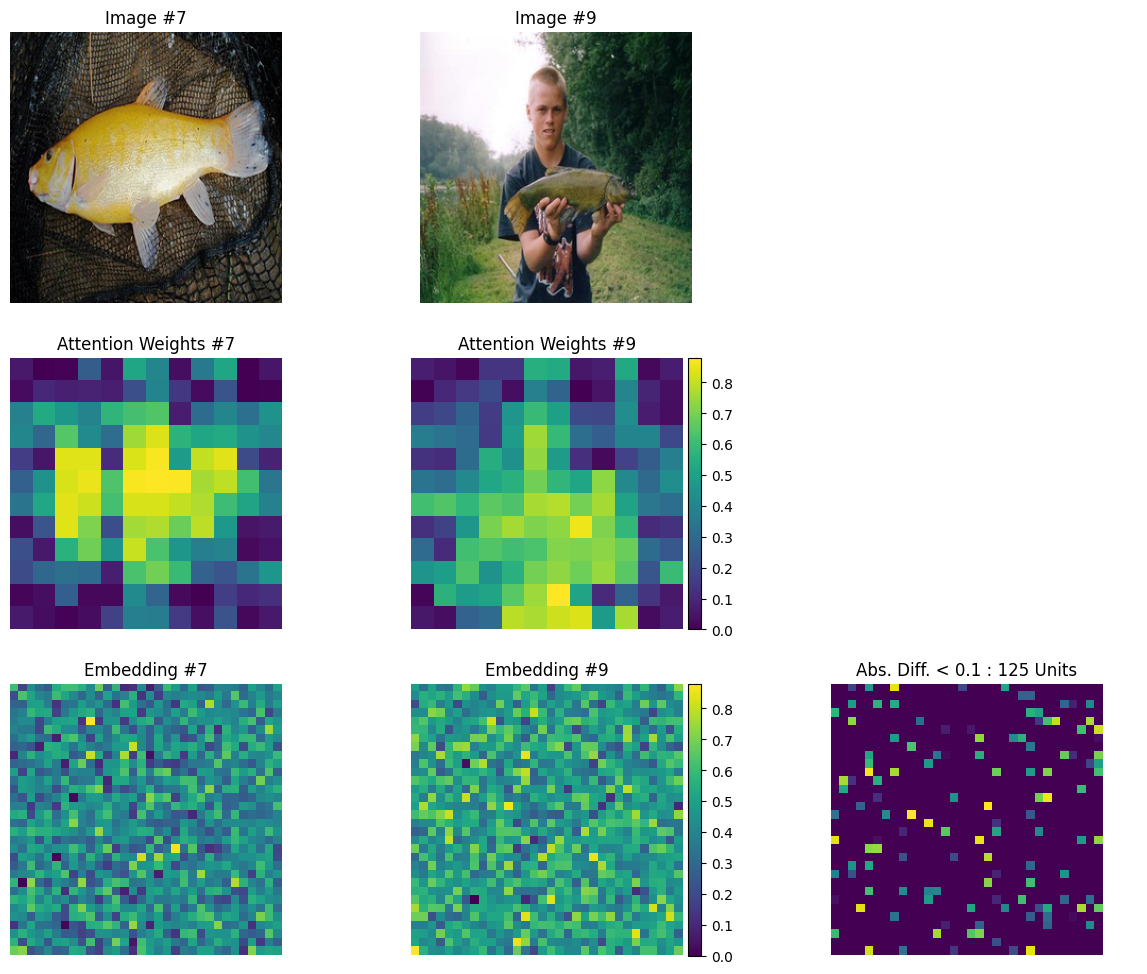

In [5]:
plot_embed_comparison(DATA, 7, 9, 0.1)

## Context-Based Image Search
The following code computes the similarity scores between the images based on their vision embeddings. To do this, I use the inverse of the euclidean distances as the similarity function, where 1 is 100% similarity and 0 is 100% *dissimilarity*.

Notice that each similarity vector is scaled by the half the length of the source embedding. This is so that if an embedding is "half the length of the source vector" away from the source vector, its similarity will be 50%.

Also notice that this generates a symmetric matrix.

In [6]:
embeds = torch.tensor(list(DATA["embedding"]))
scale = torch.norm(embeds, dim=1).mean() / 2
SIMILARITY_MATRIX = scale / (scale + torch.cdist(embeds, embeds))

del embeds, scale

SIMILARITY_MATRIX

tensor([[1.0000, 0.3424, 0.3707,  ..., 0.2578, 0.2780, 0.2664],
        [0.3424, 1.0000, 0.3544,  ..., 0.2607, 0.2779, 0.2677],
        [0.3707, 0.3544, 1.0000,  ..., 0.2746, 0.2935, 0.2776],
        ...,
        [0.2578, 0.2607, 0.2746,  ..., 0.9992, 0.3803, 0.3557],
        [0.2780, 0.2779, 0.2935,  ..., 0.3803, 1.0000, 0.3614],
        [0.2664, 0.2677, 0.2776,  ..., 0.3557, 0.3614, 0.9987]])

In [7]:
print("Is symmetric:", (SIMILARITY_MATRIX == SIMILARITY_MATRIX.T).all())

Is symmetric: tensor(False)


<Figure size 640x480 with 0 Axes>

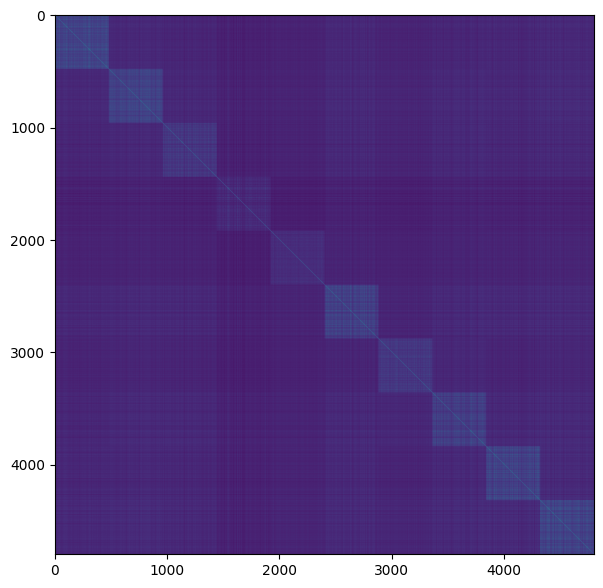

In [8]:
plt.clf()
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax.imshow(SIMILARITY_MATRIX)
plt.show()

As seen by the brighter squares along the diagonal (because the dataset is sorted in order of IMAGENET category), the model correctly assigns high similarity to images having the same categories.

### Find Similar Imagaes
Now that we have a similarity matrix, we can search for similar images based on context.

In [9]:
def find_similar(query):
    top_20 = reversed(np.argsort(SIMILARITY_MATRIX[query])[-21:])[1:] # Search top 20
    data = DATA[["image", "captions", "category"]].loc[top_20]

    similarity_scores = SIMILARITY_MATRIX[query][top_20] * 100

    plt.clf()
    _, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,18))
    for i in range(5): ax[0,i].axis('off')

    ax[0,2].imshow(DATA.loc[query]["image"])
    ax[0,2].set_title("Query Image")

    for idx in range(len(data)):
        sub_ax = ax[int(np.floor(idx / 5)) + 1][idx % 5]
        sub_ax.axis('off')

        if idx < len(data):
            row = data.iloc[idx]
            sub_ax.imshow(row["image"])
            cat, sim = row['category'], similarity_scores[idx]
            sub_ax.set_title(f"category: {cat}, sim: {sim:0.1f}%", fontsize=10)

    plt.show()

<Figure size 640x480 with 0 Axes>

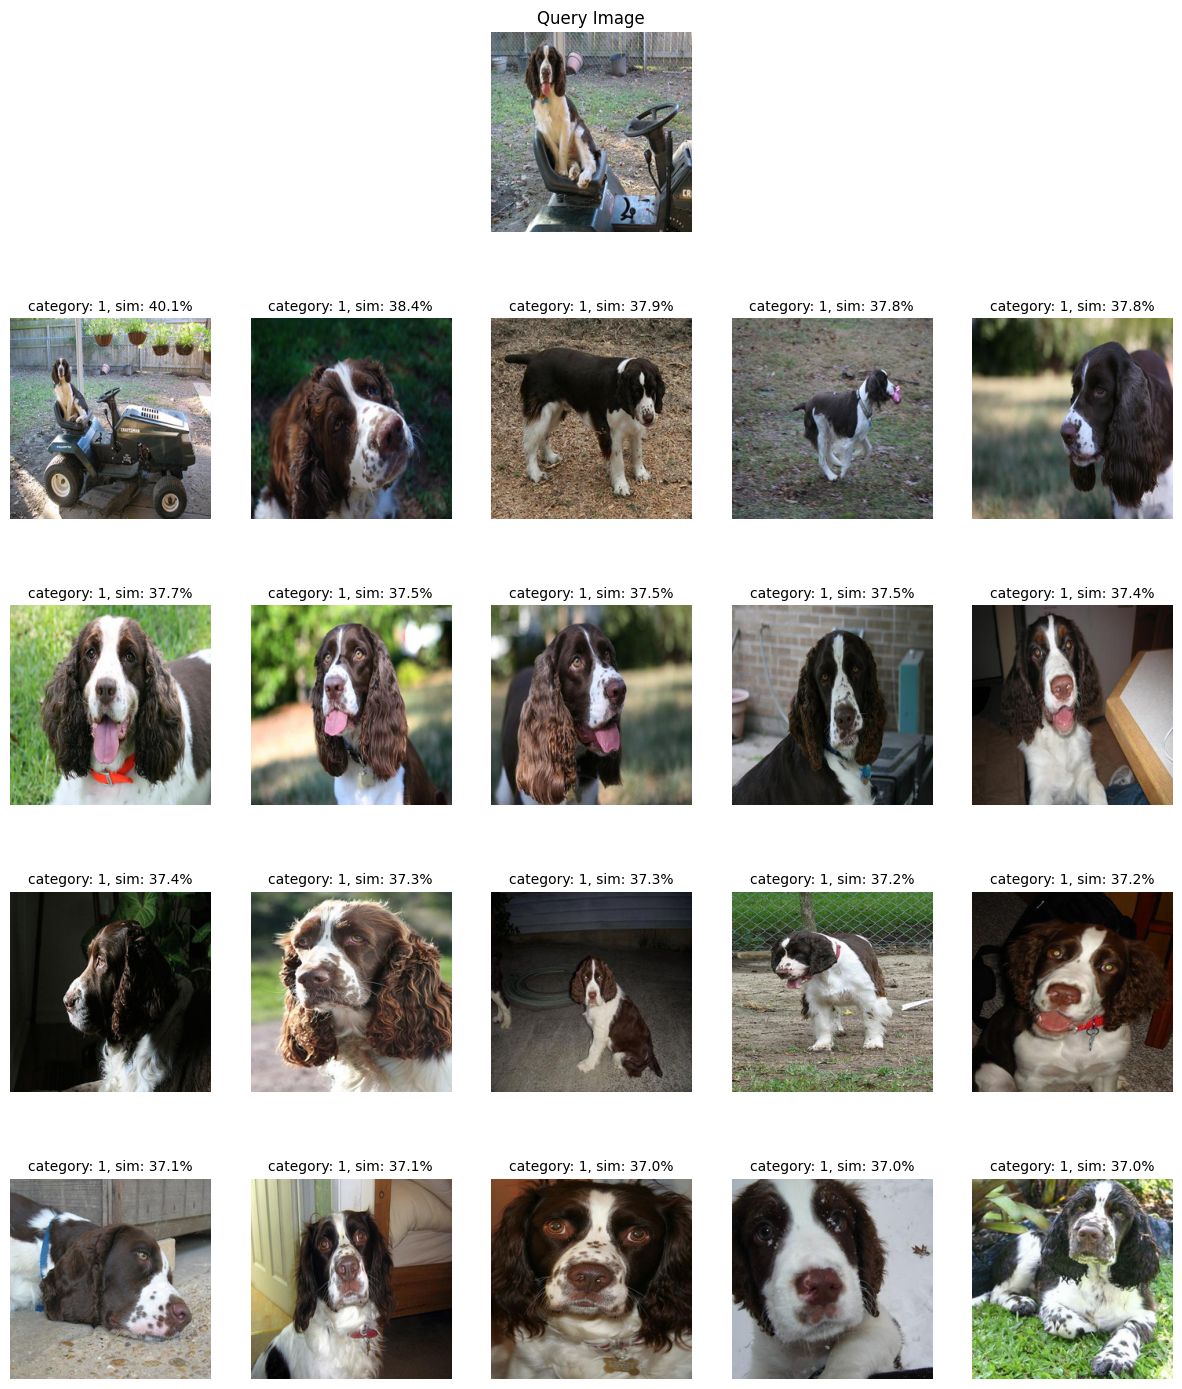

In [10]:
find_similar(520)

<Figure size 640x480 with 0 Axes>

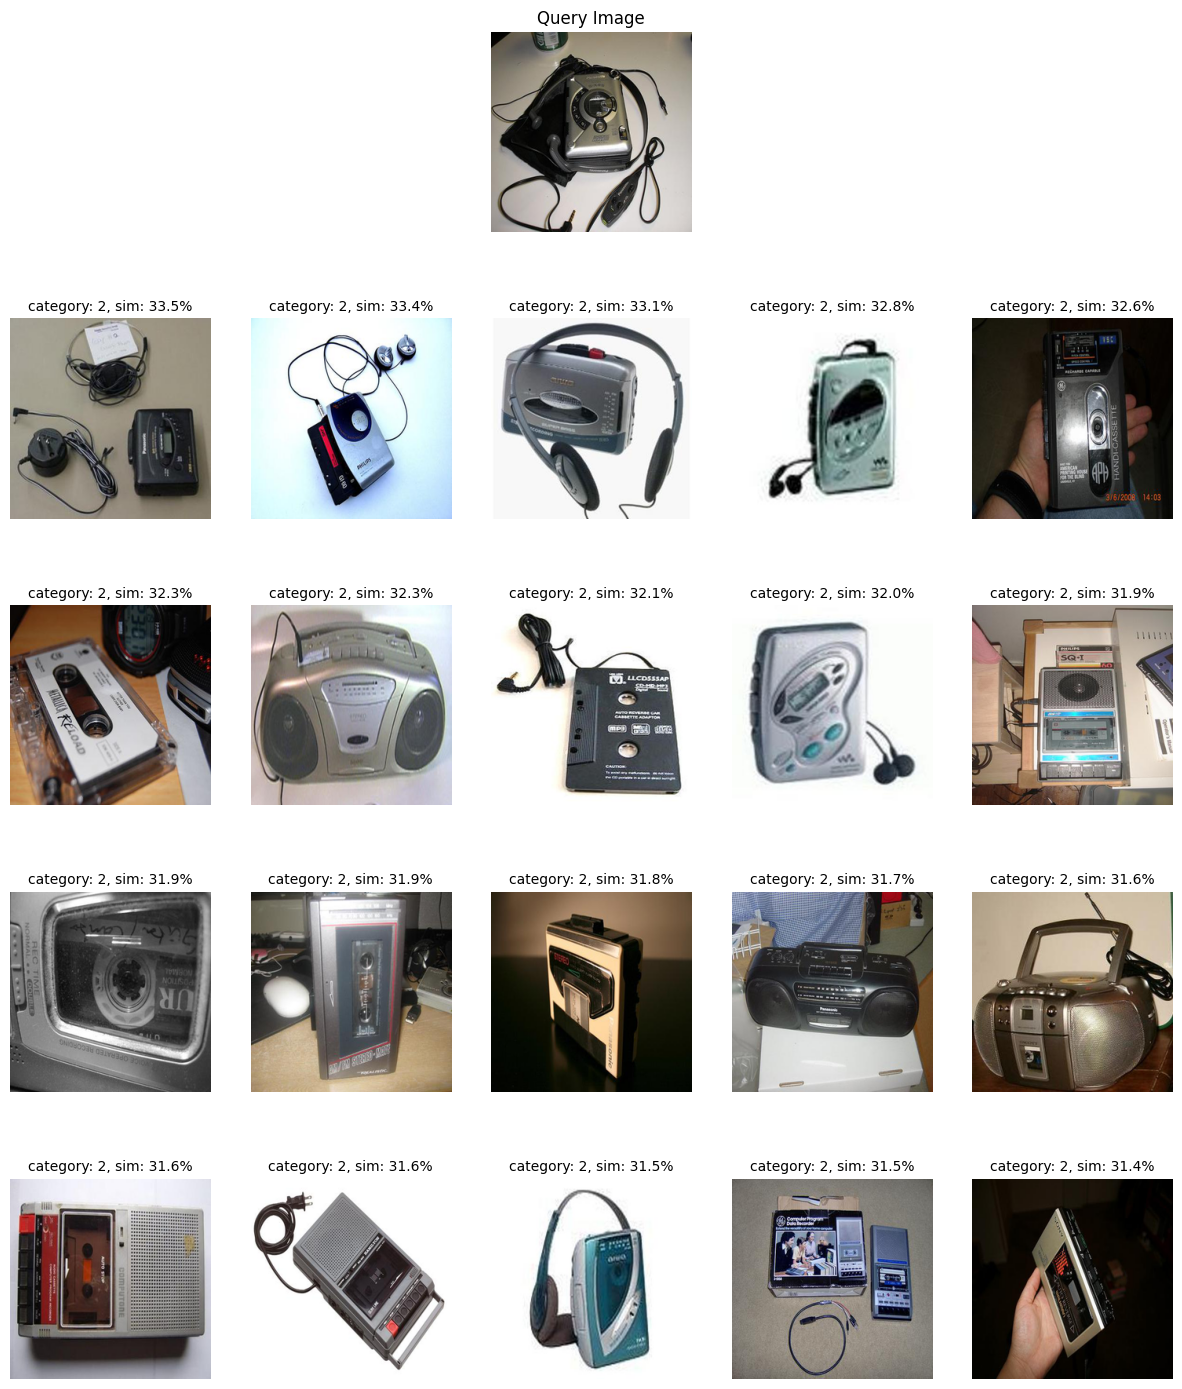

In [11]:
find_similar(1040)

<Figure size 640x480 with 0 Axes>

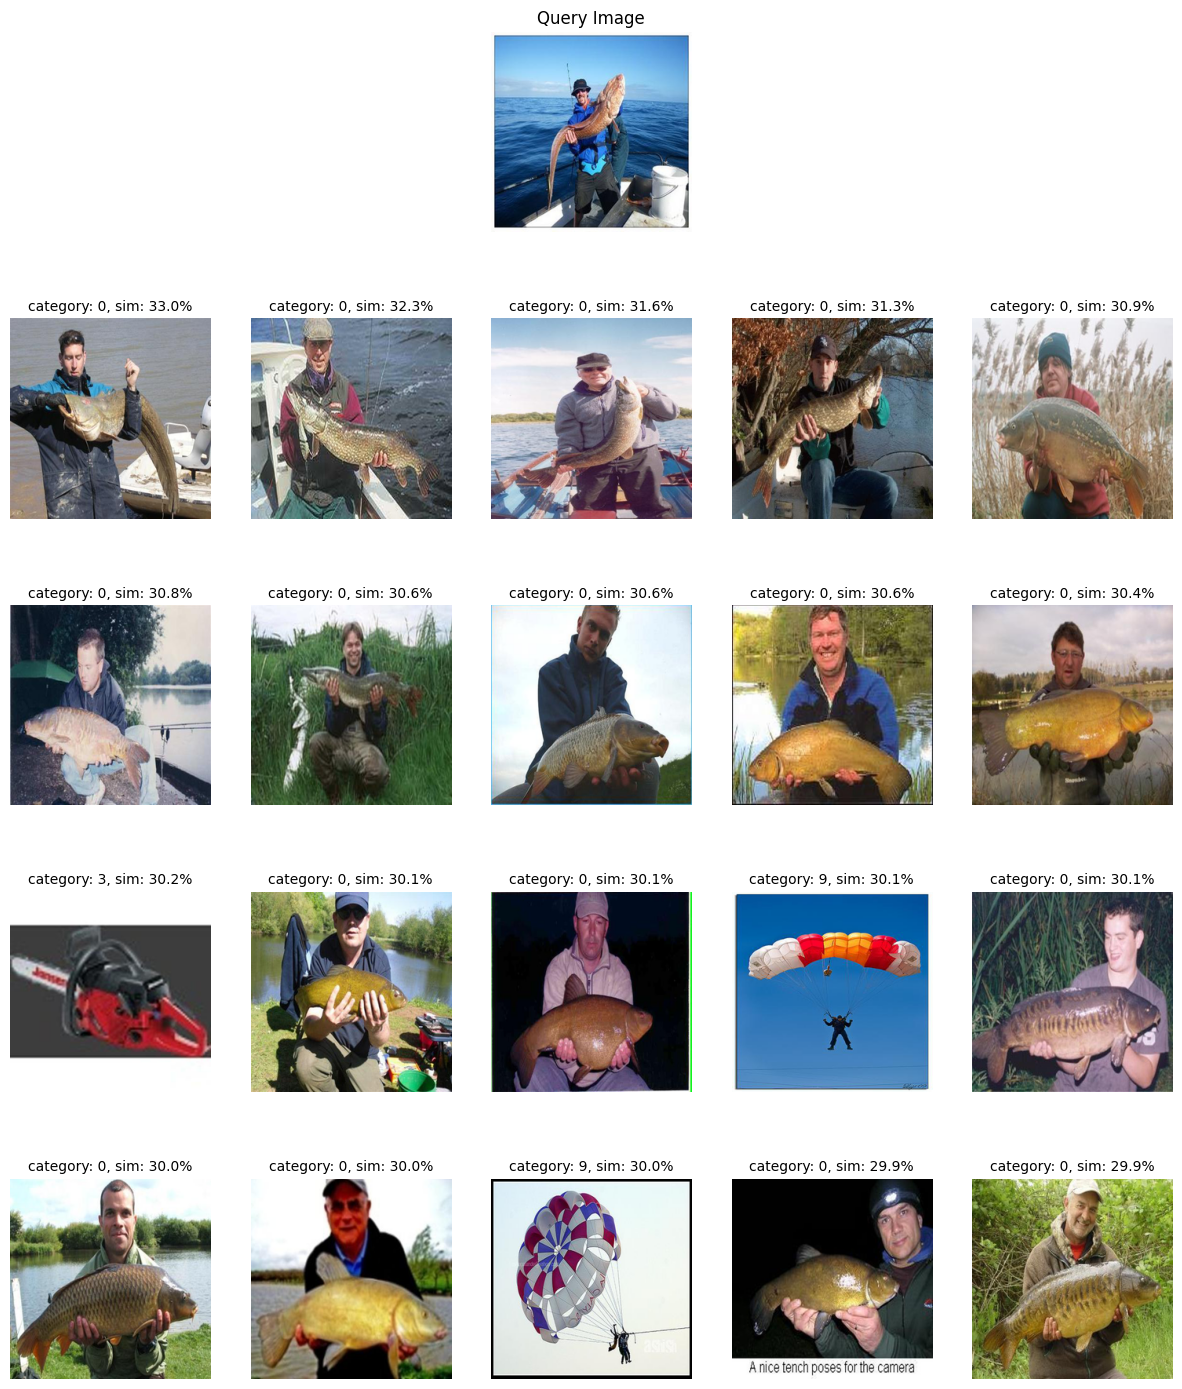

In [12]:
find_similar(10)

As we can see, the similarity search works well most of the time. However, it can sometimes confuse the images. In the case of fishing, it sometimes assigns high similarity to images of parachutes.

## The Topic Model
To find topics in the dataset, I followed a similar method to [BERTopic](https://arxiv.org/abs/2203.05794) to generate text-based descriptors from the generated captions.

### Lower Dimensionality with UMAP
Since [HDBSCAN performs better with lower dimensional data](https://hdbscan.readthedocs.io/en/latest/faq.html#q-i-am-not-getting-the-claimed-performance-why-not), I lowered the dimensions of the embeddings to 256. I also set the number of neighbors to 16 since we have a relatively small dataset. Finally, since I use the inverse euclidean function to compute embedding similarity (more on that later), I also used the euclidean similarity function as a distance metric for the UMAP algorithm.

In [13]:
embeddings_256d = umap.UMAP(
    n_neighbors=16,
    n_components=256,
    min_dist=0.0,
    metric="euclidean",
    random_state=42,
).fit_transform(list(DATA["embedding"]))

embeddings_256d

array([[ 4.2805514 , 10.375508  , 13.924832  , ...,  5.0344167 ,
         5.1804824 ,  6.396354  ],
       [ 4.2580323 , 10.412952  , 13.959625  , ...,  5.060964  ,
         5.174904  ,  6.4172325 ],
       [ 4.257597  , 10.595401  , 14.216718  , ...,  5.095028  ,
         5.1395426 ,  6.456431  ],
       ...,
       [ 0.33809677,  9.342794  ,  1.0562108 , ...,  4.6818285 ,
         5.184485  ,  6.2780905 ],
       [ 0.31053084,  9.344996  ,  1.0362635 , ...,  4.6898146 ,
         5.1838    ,  6.276762  ],
       [ 0.32500294,  9.227657  ,  1.090465  , ...,  4.722958  ,
         5.1723075 ,  6.298753  ]], dtype=float32)

### Cluster with HDBSCAN
The BERTopic paper explains that HDBSCAN is a density-based clustering algorithm that works well for topic modeling since it models noise as outliers. HDBSCAN also works well with dense clusters such as the output from UMAP.

In [14]:
clusters = hdbscan.HDBSCAN(
    min_cluster_size=256,
    metric='euclidean',
    cluster_selection_method='leaf',
).fit(embeddings_256d)

clusters

HDBSCAN(cluster_selection_method='leaf', min_cluster_size=256)

#### The Clusters in the Data

In [15]:
np.unique(clusters.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#### Assign Clusters to Each Image

In [16]:
DATA["cluster"] = clusters.labels_

del clusters, embeddings_256d

DATA

image  category   
0     [[[43, 39, 62], [41, 36, 60], [40, 36, 59], [4...         0  \
1     [[[255, 255, 251], [255, 255, 251], [255, 255,...         0   
2     [[[181, 170, 152], [193, 182, 164], [192, 181,...         0   
3     [[[110, 135, 108], [110, 136, 111], [126, 151,...         0   
4     [[[60, 60, 54], [71, 72, 66], [87, 88, 82], [6...         0   
...                                                 ...       ...   
4795  [[[235, 254, 248], [236, 254, 248], [237, 254,...         9   
4796  [[[254, 254, 254], [254, 254, 254], [254, 254,...         9   
4797  [[[41, 69, 112], [42, 71, 113], [40, 71, 112],...         9   
4798  [[[166, 173, 183], [166, 173, 183], [166, 173,...         9   
4799  [[[0, 34, 118], [0, 29, 113], [0, 30, 116], [3...         9   

                                      attention_weights   
0     [0.05418964475393295, 0.02181175723671913, 0.7...  \
1     [0.05811980739235878, 0.010085792280733585, 0....   
2     [0.04152180999517441, 0.26502525806427, 0.7568...   
3     [0.06863167136907578, 0.020426800474524498, 0....   
4     [0.07256149500608444, 0.014937695115804672, 0....   
...                                                 ...   
4795  [0.04415711760520935, 0.10343631356954575, 0.5...   
4796  [0.07850949466228485, 0.058887965977191925, 0....   
4797  [0.06918736547231674, 0.05884794145822525, 0.6...   
4798  [0.06393760442733765, 0.01447345782071352, 0.3...   
4799  [0.06283631920814514, 0.6253599524497986, 0.03...   

                                              embedding   
0     [0.3958092927932739, -0.41102686524391174, 0.0...  \
1     [0.04505084827542305, 0.4904085695743561, 0.07...   
2     [0.5317907929420471, -0.8023494482040405, 0.09...   
3     [0.30099257826805115, -0.8238896131515503, 0.0...   
4     [0.30781498551368713, -0.7023441791534424, 0.0...   
...                                                 ...   
4795  [1.0861889123916626, -0.38086405396461487, 0.0...   
4796  [0.6354748606681824, -0.8015273213386536, 0.09...   
4797  [0.38840368390083313, 0.36730003356933594, 0.0...   
4798  [0.23467440903186798, -0.7407791614532471, 0.0...   
4799  [0.7648059725761414, -0.1952364146709442, 0.08...   

                                               captions  cluster  
0     there is a man kneeling down holding a fish in...        1  
1     arafed fish caught on a fishing trip in the co...        1  
2     arafed man holding a fish on a beach near a bo...        1  
3     arafed fish caught in the river by a man in a ...        1  
4       a man kneeling down holding a fish in his hands        1  
...                                                 ...      ...  
4795  there are many children standing under a large...        5  
4796  araffe flying a kite in a field with a car in ...        5  
4797      there are two people flying a kite on a beach        5  
4798     araffe flying a kite with a british flag on it        5  
4799  araffes flying in the sky with a parachute in ...        5  

[4800 rows x 6 columns]

### Plot Clusters in 2D

In [17]:
embeddings_2d = umap.UMAP(
    n_neighbors=16,
    n_components=2,
    min_dist=0.0,
    metric="euclidean",
    random_state=42,
).fit_transform(list(DATA["embedding"]))

embeddings_2d

array([[16.555056 , -4.7151184],
       [16.72298  , -4.8634133],
       [17.713236 , -4.9235816],
       ...,
       [ 6.222778 ,  3.29135  ],
       [ 6.204677 ,  3.3436065],
       [ 5.7808614,  4.0910697]], dtype=float32)

In [18]:
alt.Chart(pd.DataFrame({
    "x": embeddings_2d[:, 0],
    "y": embeddings_2d[:, 1],
    "cluster": DATA["cluster"],
    "caption": DATA["captions"],
})).mark_circle(size=60).encode(
    x='x:Q',
    y='y:Q',
    color='cluster:N',
    tooltip=['cluster:N', 'caption:N']
).properties(
    width=800,
    height=800,
).interactive()

alt.Chart(...)

In [19]:
del embeddings_2d

### Class-Based Term-Frequency Inverse-Document-Frequency
This allows us to find the frequency and relevancy of a word in a cluster relative to other clusters.

In [20]:
def generate_c_tf_idf(docs_per_topic, clustered_embeddings_2d):
    count = CountVectorizer(
        ngram_range=(1, 1),
        stop_words="english"
    ).fit(docs_per_topic["captions"].values)

    t = count.transform(docs_per_topic["captions"].values).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(len(clustered_embeddings_2d), sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count


topic_data = DATA[["captions", "cluster"]]
grouped_docs = topic_data.groupby(['cluster'], as_index=False).agg({'captions': ' '.join})
c_tf_idf, count = generate_c_tf_idf(grouped_docs, topic_data)

grouped_docs

cluster                                           captions
0        0  arafed golf ball near a hole with a marker on ...
1        1  there is a man kneeling down holding a fish in...
2        2  puppy laying on a couch with his paw on the ar...
3        3  arafed man working on a wooden box in a junkya...
4        4  yellow radio sitting on a white chair next to ...
5        5  araffe juggling a ball with a stick in front o...
6        6  arafed photo of a church with a clock on the f...
7        7  arafed woman sitting on the floor with cell ph...
8        8  arafed silver car parked in a parking lot with...
9        9  a close up of a toy robot with a white backgro...

#### Extract top 10 Words From Each Topic

In [21]:
def extract_top_n_words_per_topic(c_tf_idf, count: CountVectorizer, n=20):
    words = count.get_feature_names_out()
    labels = sorted(list(grouped_docs["cluster"]))
    tf_idf_transposed = c_tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {
        label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)
    }
    return top_n_words


n_top_words = 10
top_words = extract_top_n_words_per_topic(c_tf_idf, count, n_top_words)


#### Display Top 10 Words per Topic

In [22]:
c_ids = list(sorted(top_words.keys()))
if -1 in top_words.keys():
    c_ids = c_ids[1:]
    c_ids.append(-1)

n_cols = 2

for start in range(0, len(c_ids), n_cols):
    current_ids = c_ids[start:(start+n_cols)]

    print("-"*(33*len(current_ids) + n_cols))
    for i, c_id in enumerate(current_ids):
        idx = "|  " if i == 0 else ""
        end = "\n" if i == len(current_ids) - 1 else ""
        msg = f"Topic #{c_id}" if c_id != -1 else "Outliers (-1)"
        print(idx, msg.ljust(29), "| ", end=end)
    print("-"*(33*len(current_ids) + 2))

    for i, word_scores in enumerate(zip(*[top_words[i] for i in current_ids])):
        for j, (word, score) in enumerate(word_scores):
            end = " " if j < len(word_scores) else "\n"
            idx = str(i + 1).ljust(3) if j == 0 else ""
            print(idx, word.ljust(20), str(score.round(5)).ljust(8), "|", end=end)
        print()
    print()

--------------------------------------------------------------------
|   Topic #0                      |  Topic #1                      | 
--------------------------------------------------------------------
1   golf                 0.41285  |  fish                 0.42141  | 
2   ball                 0.32763  |  holding              0.22051  | 
3   close                0.18265  |  man                  0.19609  | 
4   balls                0.17148  |  caught               0.17625  | 
5   grass                0.10705  |  hands                0.14238  | 
6   green                0.10309  |  kneeling             0.13034  | 
7   tee                  0.08229  |  araffe               0.10046  | 
8   field                0.06633  |  arafed               0.09745  | 
9   club                 0.04815  |  net                  0.09248  | 
10  hole                 0.04744  |  river                0.07655  | 

--------------------------------------------------------------------
|   Topic #2          